
## Wind-Wave-Bubble Gas Transfer Velocity Formulation (Deike et al., 2025)
==========================

Authors: Luc Deike, Paridhi Rustogi, Xiaohui Zhao (Princeton University) 

Creation Date: March 01, 2025  

Description:
This script uses the D25 wind-wave-bubble formulation to reproduce Figure 3 from the main text (without DMS).

==========================

Input Variables:
- Wind Speed (m/s): JRA55-do v1.5 forcing (Tsujino et al., 2018).
- Significant Wave Height (m): Wavewatch III (WAVEWATCH III Development Group. (2016))
- Gas Properties: Ostwald solubility and diffusivity from Wanninkhof (2009).

This script models the interaction of wind, waves, and gas transfer, contributing to the understanding of oceanic gas exchange processes.

==========================

/projects/GEOCLIM/LRGROUP/prustogi/kw_simulations_2024/Notebooks_Processing/Oxygen/code_PNAS


/home/pr7874/.conda/envs/gases/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Load dependencies

In [6]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'O2', 'CO2']

# Ostwald solubility (dimensionless) and diffusivity (cm^2/s) values from Wanninkhof (2009)
Alpha = {gas: alpha for gas, alpha in zip(gases, [0.008, 0.009, 0.028, 0.05, 0.1, 0.025, 0.8])}
D = {gas: D for gas, D in zip(gases, [6.36e-9, 3.33e-9, 1.82e-9, 1.51e-9, 1.19e-9, 1.78e-9, 1.59e-9])}

nu = 1.07e-3 / 1021  # Kinematic viscosity of seawater (m^2/s - viscosity in Pa.s/1021)
Sc = {gas: nu / D[gas] for gas in gases}

# Constants
g = 9.81          # gravitational acceleration constant (m/s^2)

# Conversion factor
convert_ms_cmhr = 3600 * 100

# Coefficients for the wind-wave-bubble gas transfer velocity calculation using COARE 3.5 for wind friction to U10 relationship
# - Refer to Table S1 and Table S2 for more details.
A_nb    = 1.33e-4 # Unbroken
A_bsym  = 1.2e-5  # Symmetric bubbles
A_basym = 7e-8    # Asymmetric bubbles 

## Extract HiWinGS data (Brumer et al., 2017) -->

In [8]:
from scipy.io import loadmat
data = loadmat('highwings_trk_data.mat')  

lat, lon, time = data['lat_trk'], data['lon_trk'], data['time_trk']
lon_circ = 360 - lon

ust, uwnd = data['ust_trk'][0], data['uwnd_trk'][0]
vst, vwnd = data['vst_trk'][0], data['vwnd_trk'][0]
hs = data['hs_trk'][0]

u10   = np.sqrt(uwnd**2+vwnd**2) # 10 m wind speed (m/s)
ustar = np.sqrt(ust**2+vst**2)   # Wind friction velocity (m/s)

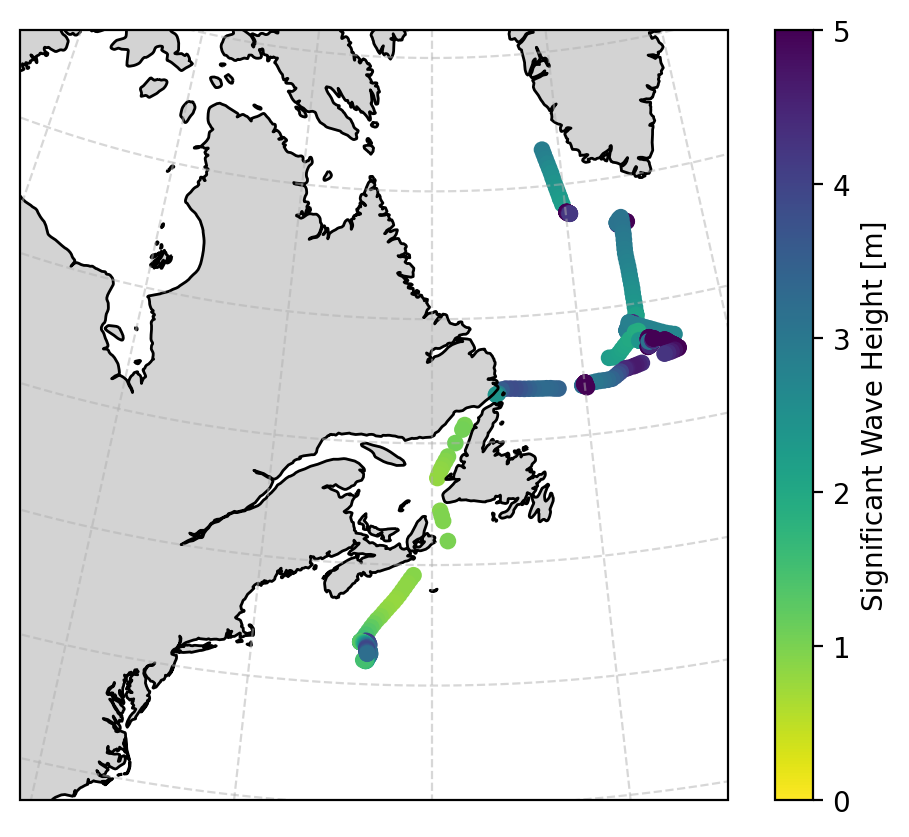

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.LambertConformal(central_longitude=-60, central_latitude=50)
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw={'projection': projection})

ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sc = ax.scatter(-(lon_circ), lat, c=hs, cmap='viridis_r', vmin=0, vmax=5, edgecolor='None', transform=ccrs.PlateCarree())
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label="Significant Wave Height [m]",)

ax.set_extent([-81, -45, 35, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

plt.show()

### Histograms of wind speed and wave heights -->

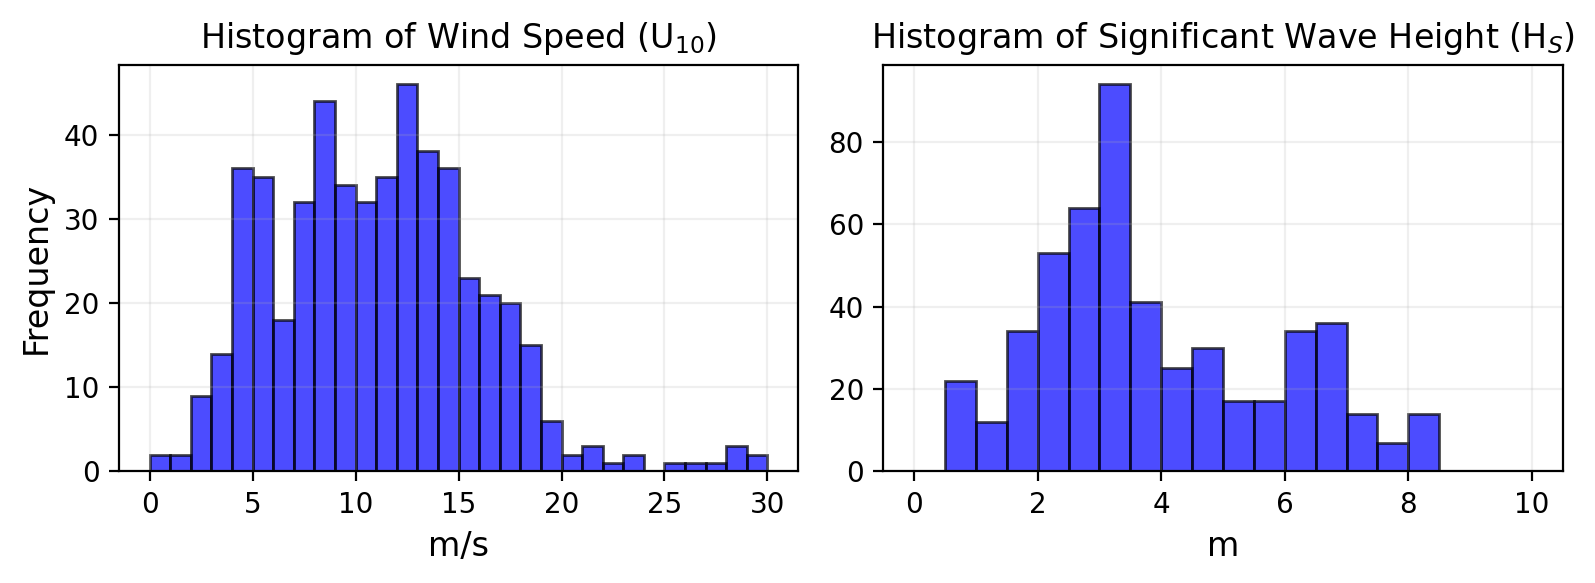

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for U10 (Wind Speed)
axes[0].hist(u10, bins=np.linspace(0, 30, 31), color='blue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('m/s', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Histogram of Wind Speed (U$_{10}$)', fontsize=12)
axes[0].grid(alpha=0.2)

# Histogram for Hs (Significant Wave Height)
axes[1].hist(hs, bins=np.linspace(0, 10, 21), color='blue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('m', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].set_title('Histogram of Significant Wave Height (H$_{S}$)', fontsize=12)
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Calculate the symmetric and asymmetric terms

In [11]:
def k_nb(A_nb, ustar, sc):
    k_nb = A_nb * ustar * (sc/660)**(-1/2)
    "    -- Returns function in units of m/s"
    return k_nb    
    
def k_bsym(A_bsym, alpha, ustar, hs, sc):
    
    ''' alpha   : Ostwald Solubility (unitless) 
            -- if you have solubility (Ko) in units of mol/m^3 - convert to Ostwald solubility
            -- alpha  = Ko * atm2pa * R * sst_K * rho_water # (Ostwald solubility)  
                -- atm2pa    = 1./101325, 
                -- R         = 8.314 (kg m^2)/(s^2 (K mol)) 
                -- sst_K     = sst+273.15 where sst is in degC
                -- rho_water = 1035 (kg/m3)
        Ustar: Air-side frictional velocity (in m/s)
        Sc   : Schmidt Number (dimensionless)
        Hs   : Significant Wave Height (in m)
        -- Returns function in units of m/s'''
 
    # Constants
    g         = 9.81       # gravitational acceleration constant (m/s2)  

    # Calculation  
    kb_sym = A_bsym/(alpha**0.35)*(ustar**(5/3)*np.sqrt(g*hs)**(4/3)) * (sc/660)**(-1/2)
    return kb_sym

def k_basym(A_basym, alpha, ustar, hs):

    ''' alpha   : Ostwald Solubility (unitless) 
            -- if you have solubility (Ko) in units of mol/m^3 - convert to Ostwald solubility
            -- alpha  = Ko * atm2pa * R * sst_K * rho_water # (Ostwald solubility)  
                -- atm2pa    = 1./101325, 
                -- R         = 8.314 (kg m^2)/(s^2 (K mol)) 
                -- sst_K     = sst+273.15 where sst is in degC
                -- rho_water = 1035 (kg/m3)
        Ustar: Air-side frictional velocity (in m/s)
        Hs   : Significant Wave Height (in m)
         -- Returns function in units of m/s'''
 
    # Constants
    g         = 9.81 #(m/s)
    
    # Calculation
    kb_asym = A_basym/(alpha**0.65)*(ustar**(5/3)*np.sqrt(g*hs)**(4/3))
    return kb_asym

In [12]:
kw_sym_gases = {gas: k_nb(ustar, A_nb, sc) + k_bsym(A_bsym, Alpha[gas], ustar, hs, sc) for gas, sc in Sc.items()}
kw_660_sym_gases = {gas: kw_sym_gases[gas] * (sc / 660) ** (1/2) for gas, sc in Sc.items()}

kw_asym_gases = {gas: k_basym(A_basym, alpha, ustar, hs) for gas, alpha in Alpha.items()}

## Version with only wind - fitting H$_s$ and u$_*$ dependency into U$_{10}$

The factor A_bsym_wind comes from the fit between (ustar**(5/3)*np.sqrt(g*hs)**(4/3) and (u10-2.5)**2.5,

See supplementary Table 1 in Deike et al., (2025).

In [13]:
# Coefficients
A_nb_wind    = 1.33e-4
A_bsym_wind  = 1.42e-7
A_basym_wind = 1.18e-9

kw_sym_gases = {gas: ((sc/660)**(1/2) * A_nb_wind * ustar + A_bsym_wind * (Alpha[gas])**(-0.35) * (u10 - 2.5)**(2.5)) 
    for gas, sc in Sc.items()}

kw_asym_gases = {gas: (A_basym_wind * (Alpha[gas])**(-0.65) * (u10 - 2.5)**(2.5)) for gas, sc in Sc.items()}

/tmp/ipykernel_2924602/856601502.py:6: RuntimeWarning: invalid value encountered in power
  kw_sym_gases = {gas: ((sc/660)**(1/2) * A_nb_wind * ustar + A_bsym_wind * (Alpha[gas])**(-0.35) * (u10 - 2.5)**(2.5))
/tmp/ipykernel_2924602/856601502.py:9: RuntimeWarning: invalid value encountered in power
  kw_asym_gases = {gas: (A_basym_wind * (Alpha[gas])**(-0.65) * (u10 - 2.5)**(2.5)) for gas, sc in Sc.items()}


In [14]:
from scipy import stats
wind_bins = np.linspace(0, 30, 31)  

# Initialize dictionaries to store binned means
kw_sym_binned, kw_asym_binned = {}, {}

# Compute binned means for each gas
for gas in Sc.keys():
    # Convert to NumPy arrays and flatten
    scatter_a = np.asarray(u10).flatten()
    scatter_b_sym = np.asarray(kw_sym_gases[gas]).flatten()
    scatter_b_asym = np.asarray(kw_asym_gases[gas]).flatten()

    # Mask invalid values (NaN, Inf)
    mask_sym = np.logical_and(np.isfinite(scatter_a), np.isfinite(scatter_b_sym))
    mask_asym = np.logical_and(np.isfinite(scatter_a), np.isfinite(scatter_b_asym))

    # Compute binned means for symmetric transfer velocity
    bin_means_sym, _, _ = stats.binned_statistic(
        scatter_a[mask_sym], scatter_b_sym[mask_sym], statistic='mean', bins=wind_bins
    )
    
    # Compute binned means for asymmetric transfer velocity
    bin_means_asym, _, _ = stats.binned_statistic(
        scatter_a[mask_asym], scatter_b_asym[mask_asym], statistic='mean', bins=wind_bins
    )

    # Store in dictionaries
    kw_sym_binned[gas] = bin_means_sym
    kw_asym_binned[gas] = bin_means_asym

# Convert to DataFrames for better visualization
kw_sym_binned_df = pd.DataFrame(kw_sym_binned, index=wind_bins[:-1])
kw_asym_binned_df = pd.DataFrame(kw_asym_binned, index=wind_bins[:-1])


## Figure 3a,b from Deike et al,. (2025)

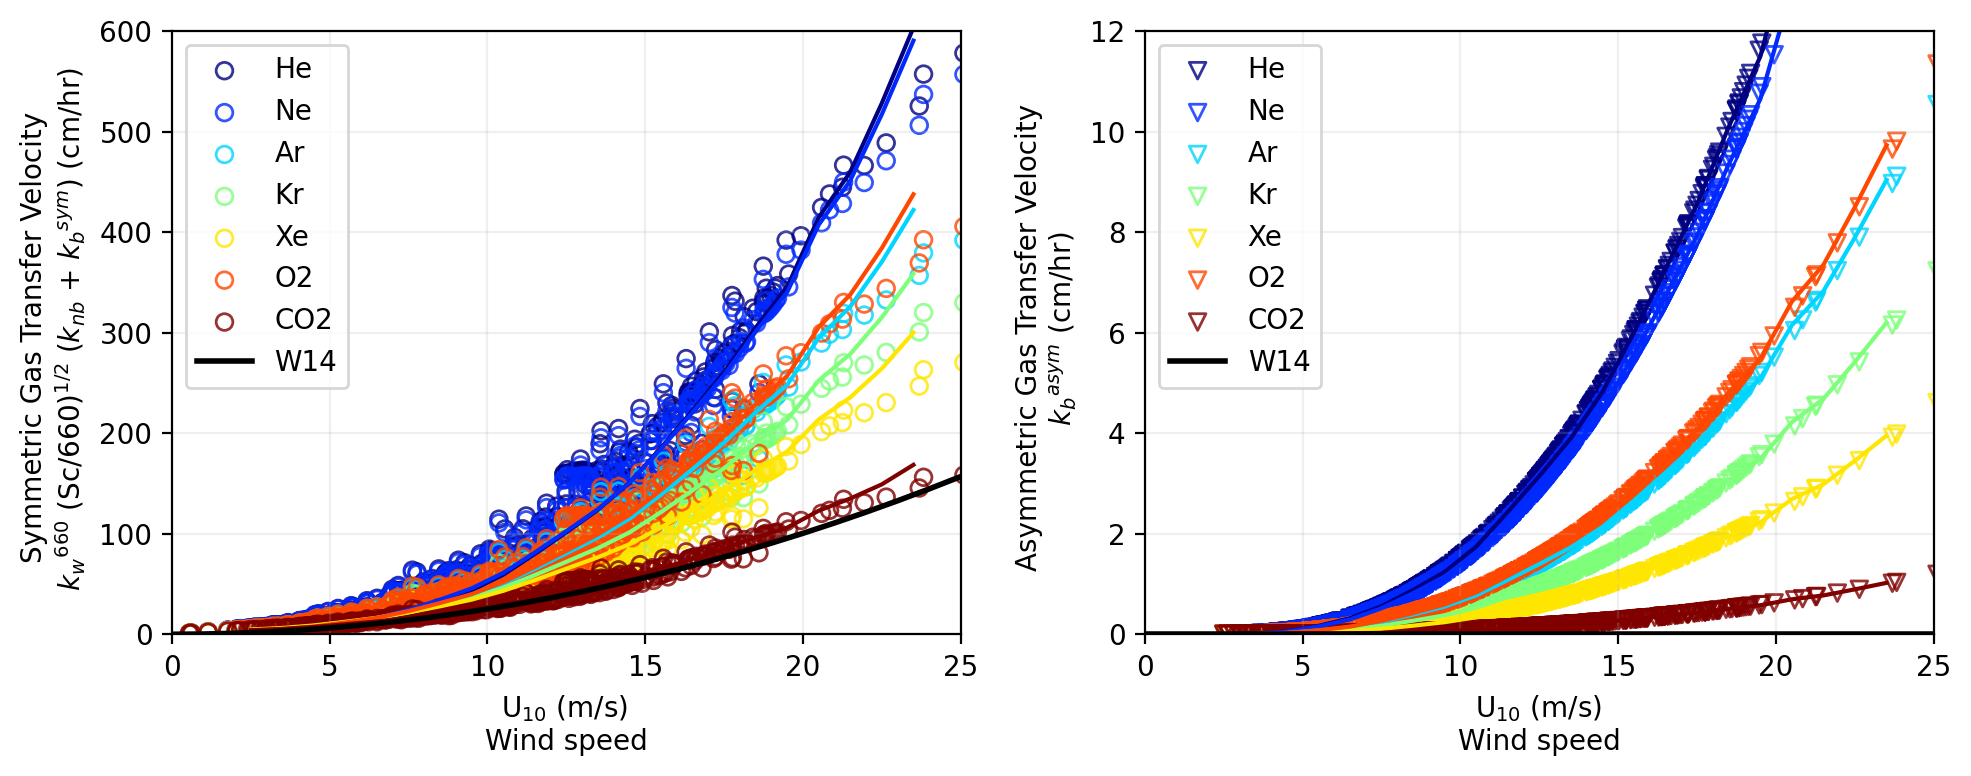

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = plt.cm.jet(np.linspace(0, 1, len(gases)))

# Symmetric gas transfer velocity plot
for i, gas in enumerate(gases):
    axes[0].scatter(u10, kw_660_sym_gases[gas]*convert_ms_cmhr , label=gas, linewidth=1, marker='o',
                    edgecolor=colors[i], facecolor='None', alpha=0.8)
    axes[0].plot(np.linspace(0.5,29.5,30), kw_sym_binned_df[gas]*convert_ms_cmhr,
                    color=colors[i])

axes[0].plot(np.arange(0, 31), 0.251 * np.arange(0, 31)**2, 'black', linewidth=2, label='W14')
axes[0].set_xlabel('U$_{10}$ (m/s) \nWind speed', fontsize=10)
axes[0].set_ylabel('Symmetric Gas Transfer Velocity \n $k_w$$^{660}$ (Sc/660)$^{1/2}$ ($k_{nb}$ + $k_b$$^{sym}$) (cm/hr)', fontsize=10)

axes[0].legend()
axes[0].grid(alpha=0.2)
axes[0].set_ylim(0, 600)
axes[0].set_xlim(0, 25)

# Asymmetric gas transfer velocity plot
for i, gas in enumerate(gases):
    axes[1].scatter(u10, kw_asym_gases[gas]*convert_ms_cmhr, label=gas, linewidth=1, marker='v',
                    edgecolor=colors[i], facecolor='None', alpha=0.8)
    axes[1].plot(np.linspace(0.5,29.5,30), kw_asym_binned_df[gas]*convert_ms_cmhr,
                    color=colors[i])

axes[1].plot(np.arange(0, 31), 0 * np.arange(0, 31)**2, 'black', linewidth=2, label='W14')
axes[1].set_xlabel('U$_{10}$ (m/s) \nWind speed', fontsize=10)
axes[1].set_ylabel('Asymmetric Gas Transfer Velocity \n $k_b$$^{asym}$ (cm/hr)', fontsize=10)

axes[1].legend()
axes[1].grid(alpha=0.2)
axes[1].set_ylim(0, 12)
axes[1].set_xlim(0, 25)

plt.tight_layout()
plt.show()

### Test for any gas

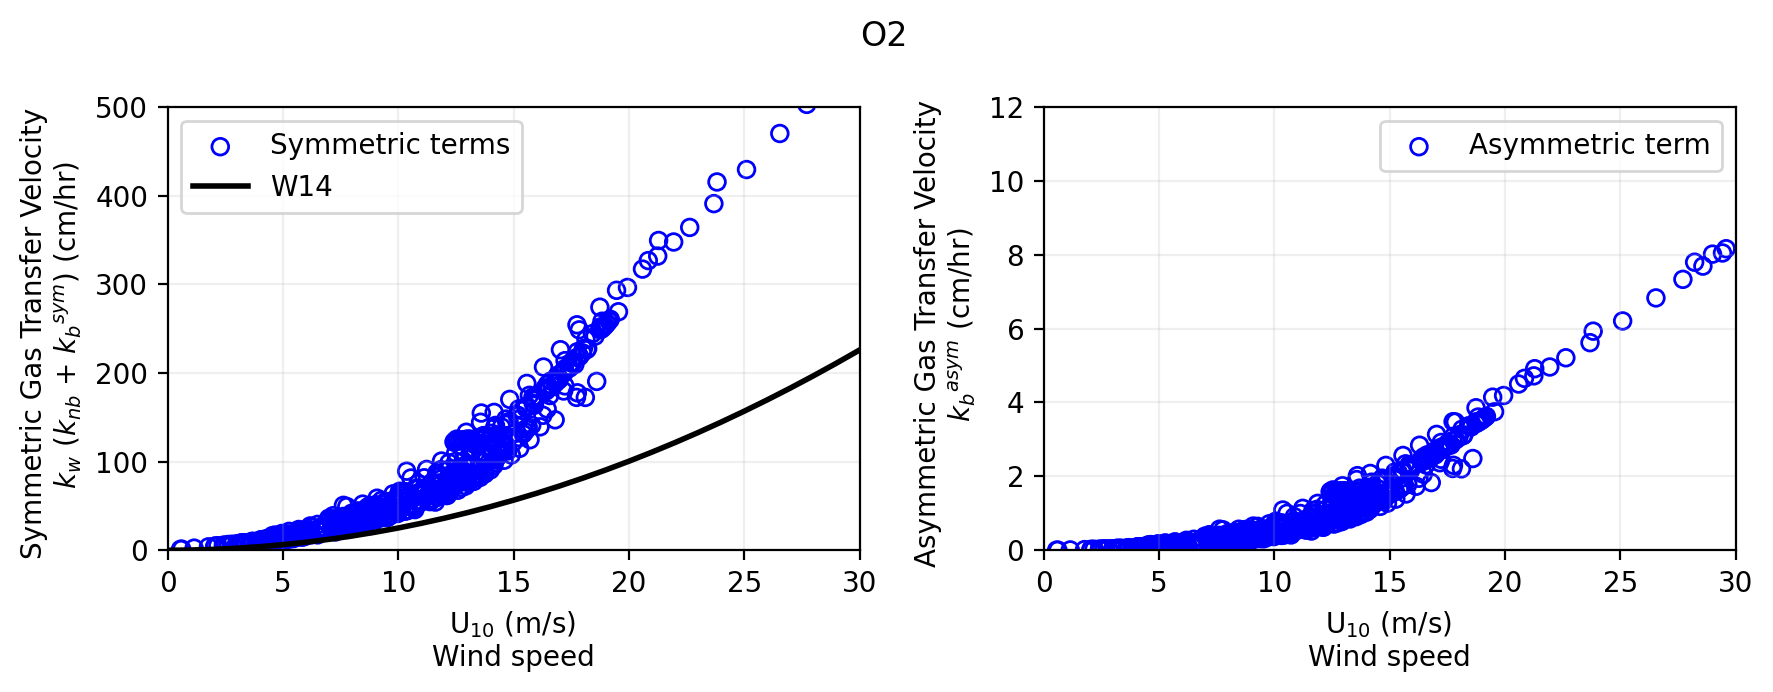

In [19]:
gas_name = 'O2'

k_nb_gas    = k_nb(A_nb, ustar, Sc[gas_name])
k_bsym_gas  = k_bsym(A_bsym, Alpha[gas_name], ustar, hs, Sc[gas_name])
k_basym_gas = k_basym(A_basym, Alpha[gas_name], ustar, hs)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5), sharex=True)

# Symmetric terms plot
axes[0].scatter(u10, (k_nb_gas + k_bsym_gas) * convert_ms_cmhr, 
                facecolor='None', edgecolor='blue', label='Symmetric terms')
axes[0].plot(np.arange(0, 31), 0.251 * np.arange(0, 31)**2, 'black', linewidth=2, label='W14')
axes[0].set_xlabel('U$_{10}$ (m/s) \nWind speed', fontsize=10)
axes[0].set_ylabel('Symmetric Gas Transfer Velocity \n $k_w$ ($k_{nb}$ + $k_b$$^{sym}$) (cm/hr)', fontsize=10)
axes[0].grid(alpha=0.2)
axes[0].legend()
axes[0].set_ylim(0,500)
axes[0].set_xlim(0,30)

# Asymmetric terms plot
axes[1].scatter(u10, k_basym_gas * convert_ms_cmhr, 
                facecolor='None', edgecolor='blue', label='Asymmetric term')
axes[1].set_ylabel("Asymmetric Gas Transfer Velocity \n $k_b$$^{asym}$ (cm/hr)", fontsize=10)
axes[1].set_xlabel('U$_{10}$ (m/s) \nWind speed', fontsize=10)
axes[1].grid(alpha=0.2)
axes[1].legend()
axes[1].set_ylim(0,12)
axes[1].set_xlim(0,30)
plt.suptitle(gas_name)

plt.tight_layout()
plt.show()